# <font color=FF3300> modification des paramètres de calcul et incertitude sur la position de la source</font>
Ce tutoriel s'inscrit dans la suite de Tutoriel_API_Code_TYMPAN-3. On modifie la configuration du calcul et on modelise le cas où il existe une incertitude sur la position d'une source.
#### On suivra les étapes
* Initialisation
* Modification des paramètres de calcul
* Récupération de la source incertaine
* Modélisation de l'incertitude
* Visualisation

### <font color=FF3300>Initialisation</font>

On importe les différentes parties propres à TYMPAN le <font color='9900CC'>Projet</font>, le <font color='9900CC'>Model</font> et le <font color='9900CC'>Solver</font> mais aussi les outils comme Source, Spectrum ou la Configuration

In [1]:
from tympan.models.project import Project 
from tympan.models.solver import Model, Solver, Source, Spectrum
from tympan.models._solver import Configuration
from tympan.solve_project import solve

On import des bibliothèques nécéssaires à la visualisation ou aux objet que l'on utilise

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt; plt.style.use('ggplot')
from random import gauss
chemin_proj = r'Mon_projet_mur.xml'

In [3]:
def resultat(my_project):
    """depuis un projet calcul le resultat le sauvegarde dans le projet et le renvoie """
    my_model = Model.from_project(my_project)
    my_solver = Solver.from_project(my_project,verbose=True)
    my_result = my_solver.solve(my_model)
    my_project.import_result(my_model,my_result)
    return my_result

### <font color=FF3300>Modification des paramètres de calcul</font>

On sauvegarde la configuration du projet, on modifie quatre valeurs on calcule le résultat avant de remettre la configuration par défaut
* ```python
Config.get() #On récupère la configuration du projet```
* ```python 
save = open(r'config_save','w')
save.write(my_config)
save.close()```
On pourra en savoir plus avec ce [tutoriel lecture de fichier](https://openclassrooms.com/courses/apprenez-a-programmer-en-python/les-fichiers-2)
* ```python
my_config.setAtmosHygrometry(4) #Permet de modifier l'hygrometrie```
Il a de nombreux paramètres de configuration, ils ont tous un getter et un setter
* ```python
my_solver._set_solver_config(r'config_save') #Permet de mettre donner au solver un fichier de configuration ```

In [4]:
my_project = Project.from_xml(chemin_proj,verbose=True)
my_config = Configuration.get()
nv_param = {"AtmosHygrometry":4, "AtmosTemperature":40, "WindDirection":90, "AtmosPressure":10100}
solve(chemin_proj, chemin_proj, r'a_supprimer',os.environ.get('TYMPAN_SOLVERDIR'), parameters =nv_param, verbose=True)
#le resultat est visible dans l'IHM mais la configuration choisie n'est pas conservée
my_config.setAtmosTemperature(40)
#Ici la configuration est sauvegardée
res1 = resultat(my_project)
#on regarde le résultat



D:\Tympan_exe\TYMPAN_exe\cython_d\tympan\altimetry\builder.py:71: RuntimeWarning: main site landtake (or surrounding level curve) does not appear to be closed; closing it for altimetry processing
  RuntimeWarning)


### <font color=FF3300> Récupération de la source incertaine</font>

* ```python
my_model.sources[0] #Donne la première source du projet```
* ```python
source.spectrum.to_dB() # On récupère le spectre(en dB) de la source incertaine```
* ```python
posy = source.position.y
posx = source.position.x #On récupère la position de la source incertaine ```

In [5]:
n=100
my_project = Project.from_xml(chemin_proj, verbose=True)
my_model = Model.from_project(my_project, set_sources=True)
source = my_model.sources[0]
spec = source.spectrum.to_dB() #On ne peut pas récuperer le spectre directement sinon ça plante
posy = source.position.y
posx = source.position.x
my_solver = Solver.from_project(my_project,verbose=True)
res = []
Y = []

D:\Tympan_exe\TYMPAN_exe\cython_d\tympan\altimetry\builder.py:71: RuntimeWarning: main site landtake (or surrounding level curve) does not appear to be closed; closing it for altimetry processing
  RuntimeWarning)


### <font color=FF3300> Modélisation de l'incertitude</font>
Ici on modélise une incertitude sur la position d'une source. On crée $n$ fois une source que l'on place selon une loi normale autour de 10 pour sa coordonée x. Ensuite pour chaque récépteur on regarde l'infulence de cette source en fonction de sa position.
On différentie les UserSource et les Sources, les UserSources sont visibles sur l'IHM tandis que les Sources ne sont que des sources de calcul, dans notre cas la source étant "virtuelle" il est plus logique d'utiliser une Source et pas une UserSource.
* ```python
gauss(posy,40) #Tire selon une loi normale de paramètre (posy,40) ```
* ```python
my_model.add_source(nv_source) #On ajoute la source au modèle ```
* ```python
my_result.spectrum(idrec,idsrc).dBA #donne la valeur globale de la source idsrc sur le recepteur idrec ```
* ```python
res #contiendra par récépteur les valeurs globale pour les n position de la source ```


In [6]:
for _ in range(n):
    pos_y = gauss(posy,40)
    Y.append(pos_y)
    nv_source = Source((posx,pos_y,2),spec)
    my_model.add_source(nv_source)
    #del source
my_result = my_solver.solve(my_model)
for idrec in range(my_model.nreceptors):
    rec = []
    for idsrc in range(my_model.nsources-n,my_model.nsources):
        rec.append(my_result.spectrum(idrec,idsrc).dBA)
    res.append(rec)

### <font color=FF3300> Visualisation </font>
* ```python
plt.scatter(X,res[i]) #permet de tracer un nuage de point ```
On pourra en savoir plus sur matplotlib grâce à ce [tutoriel matplotlib](https://matplotlib.org/users/index.html)

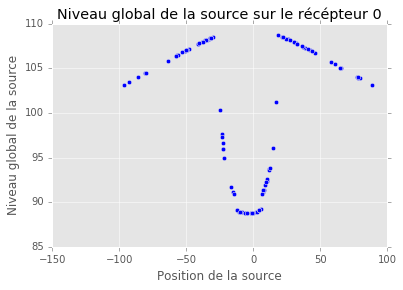

In [7]:
#On fait le postraitement
for i in range(my_model.nreceptors):
    plt.figure()
    plt.title("Niveau global de la source sur le récépteur " + str(i))
    plt.xlabel("Position de la source")
    plt.ylabel("Niveau global de la source")
    plt.scatter(Y,res[i])
plt.show()